# Extracting from free text with MedCAT

This tutorial serves as an introduction on how to use *ehrapy* together with [MedCAT](https://github.com/CogStack/MedCAT). *MedCat* is a tool to extract medical entities from free text and link it to biomedical ontologies. Biomedical entities could be anything biomedical; not only diagnoses or diseases but also symptoms, drugs or even peptides. 
It also tries to keep the context of an extracted entitiy (for example, whether a specific disease has been diagnosed or not). This is especially important for electronic health records data, as most of the time doctors notes are simply copied and pasted into the data and not preprocessed in any form. Consider the following example:

- The patient suffers from diabetes.

 vs.
 
- The patient does not suffer from diabetes.


In detail, ehrapy uses a pretrained and packages model from MedCat (https://medcat.readthedocs.io/en/latest/main.html#models). This model is limited in performance but good enough for this demonstration. A larger (trained) model is planned to be released somewhen in the (near) future by the MedCAT maintainers.

In [1]:
import ehrapy as ep
import pandas as pd

In [2]:
ep.settings.n_jobs = 2

Download the example data

In [3]:
!wget -nc https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/pt_notes.csv -P ./medcat_data/
!wget -nc https://medcat.rosalind.kcl.ac.uk/media/medmen_wstatus_2021_oct.zip -P ./medcat_data/

File ‘./medcat_data/pt_notes.csv’ already there; not retrieving.

File ‘./medcat_data/medmen_wstatus_2021_oct.zip’ already there; not retrieving.



## Custom MedCAT object of ehrapy

To allow for seemless interoperability of ehrapy and MedCAT, we require a "superobject" that references the AnnData object while providing the MedCAT functionality. This object further stores MedCAT related features such as a *vocabulary*, a *concept database* and (later on in this tutorial) also the *annotated results*.

First, we read the example data into an AnnData object, encode the data and calculate neighbors for subsequent processing.
As a next step, we create the MedCAT object with a modelpack and set default TUI filters.
A full list of TUI’s can be found at: https://lhncbc.nlm.nih.gov/ii/tools/MetaMap/Docs/SemanticTypes_2018AB.txt

In [4]:
adata = ep.io.read_csv("medcat_data/pt_notes.csv", columns_obs_only=["text"])
adata_encoded = ep.pp.encode(adata, autodetect=True)
ep.pp.neighbors(adata_encoded)

# create the main ehrapy medcat object used for medical entitiy analysis using ehrapy and medcat
ep_medcat = ep.tl.MedCAT(
    adata_encoded, model_pack_path="./medcat_data/medmen_wstatus_2021_oct.zip"
)
# only use diseases and behavioural disorders diagnoses in this example by filtering by TUI
ep_medcat.set_filter_by_tui(tuis=["T047", "T048"])

2023-08-10 17:54:04,813 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `1088` x `8`.
2023-08-10 17:54:04,814 - root INFO - The original categorical values `['gender', 'category']` were added to uns.


Output()

2023-08-10 17:54:04,832 - root INFO - Encoding strings in X to save to .h5ad. Loading the file will reverse the encoding.
2023-08-10 17:54:04,837 - root INFO - Updated the original layer after encoding.
2023-08-10 17:54:04,853 - root INFO - The original categorical values `['gender', 'category']` were added to obs.


Using this model pack we can already extract entities from an example note.

In [5]:
text = "He was diagnosed with kidney failure"
doc = ep_medcat.cat(text)
doc.ents

(kidney failure,)

In [6]:
# Example output of an extracted medcat entity; note that ehrapy will deal with this automatically and the here displayed manual extraction is not required.
# CUI: Concept Unique Identifier, which is just an unique identifier for each concept extracted
ep_medcat.cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {2: {'pretty_name': 'Kidney Failure',
   'cui': 'C0035078',
   'type_ids': ['T047'],
   'types': ['Disease or Syndrome'],
   'source_value': 'kidney failure',
   'detected_name': 'kidney~failure',
   'acc': 1.0,
   'context_similarity': 1.0,
   'start': 22,
   'end': 36,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 2,
   'meta_anns': {'Status': {'value': 'Affirmed',
     'confidence': 0.9999961853027344,
     'name': 'Status'}}}},
 'tokens': []}

## Extracting and visualizing all disease entities

To extract all disease entities from our example dataset we require a complete annotation of the dataset. This step is computationally expensive and may take some time.

In [7]:
ep.tl.mc.annotate_text(ep_medcat, text_column="text", n_proc=2)

The annotated results as extracted by MedCAT are transformed and stored into a Pandas DataFrame

In [8]:
ep_medcat.annotated_results

,row_nr,pretty_name,cui,type_ids,types,meta_anns
0,0,Degenerative polyarthritis,C0029408,[T047],[Disease or Syndrome],Affirmed
1,0,Atrial Fibrillation,C0004238,[T047],[Disease or Syndrome],Affirmed
2,0,Hypertensive disease,C0020538,[T047],[Disease or Syndrome],Affirmed
3,0,Asthma,C0004096,[T047],[Disease or Syndrome],Affirmed
4,0,"Sleep Apnea, Obstructive",C0520679,[T047],[Disease or Syndrome],Affirmed
...,...,...,...,...,...,...
10781,999,Diabetes,C0011847,[T047],[Disease or Syndrome],Other
10782,999,Diabetes,C0011847,[T047],[Disease or Syndrome],Affirmed
10783,999,Diabetes,C0011847,[T047],[Disease or Syndrome],Affirmed
10784,999,Diabetes Mellitus,C0011849,[T047],[Disease or Syndrome],Affirmed


We can also get a proper overview for the top 10 most entities found in the data (affirmed diagnoses only).

In [9]:
ep.tl.mc.get_annotation_overview(ep_medcat)

 pretty_name                  type_ids   types                         n_patient_visit   n_patient_visit_percent  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Hypertensive disease         T047       Disease or Syndrome           432               42.39450441609421        
  Obesity                      T047       Disease or Syndrome           245               24.043179587831208       
  Diabetes                     T047       Disease or Syndrome           149               14.622178606476938       
  Coronary Arteriosclerosis    T047       Disease or Syndrome           127               12.463199214916584       
  Diabetes Mellitus            T047       Disease or Syndrome           118               11.579980372914623       
  Disease                      T047       Disease or Syndrome           110               10.794896957801766       
  Cerebrovascular accident     T047       Disease or Syndrome           110               10.794896957801766       
  Asthma                       T047       Disease or Syndrome           97                9.519136408243375        
  Chronic Obstructive Airway   T047       Disease or Syndrome           92                9.028459273797841        
  Disease                                                                                                          
  Mental Depression            T048       Mental or Behavioral          91                8.930323846908735        
                                          Dysfunction                                                             

Alternatively, we can also get an overview of the top 10 negated diagnoses only.

In [10]:
ep.tl.mc.get_annotation_overview(ep_medcat, status="Other")

 pretty_name                 type_ids   types                          n_patient_visit   n_patient_visit_percent  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Cerebrovascular accident    T047       Disease or Syndrome            119               15.973154362416109       
  Erythema                    T047       Disease or Syndrome            85                11.409395973154362       
  Diabetes                    T047       Disease or Syndrome            78                10.46979865771812        
  Hypertensive disease        T047       Disease or Syndrome            68                9.12751677852349         
  disorder lesions skin       T047       Disease or Syndrome            68                9.12751677852349         
  Lymphadenopathy             T047       Disease or Syndrome            64                8.590604026845638        
  nervous system disorder     T047       Disease or Syndrome            58                7.785234899328859        
  Coronary Arteriosclerosis   T047       Disease or Syndrome            50                6.7114093959731544       
  Drug abuse                  T048       Mental or Behavioral           50                6.7114093959731544       
                                         Dysfunction                                                               
  Pneumonia                   T047       Disease or Syndrome            50                6.7114093959731544      

Since our MedCAT is aware of both, the annotation results and the AnnData object, we can just pass it to any plotting functions of ehrapy, just we like we are used to with AnnData objects.
First, we calculate a UMAP embedding using the AnnData object and then we color by all patients that had some form of Pneumonia.

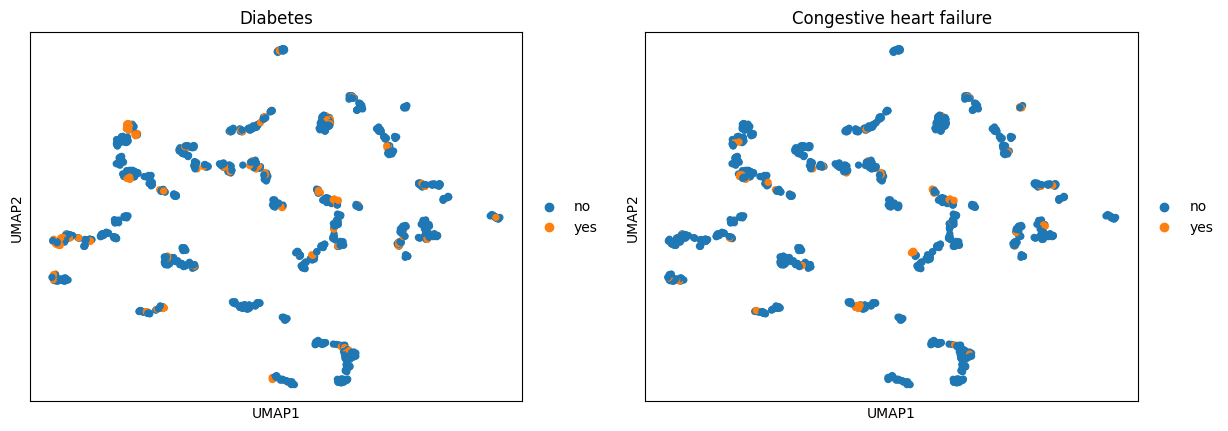

In [11]:
ep.tl.umap(ep_medcat.anndata)
ep.pl.umap(ep_medcat, color=["Diabetes", "Congestive heart failure"])

It is still possible to color by the original columns in the AnnData object with the MedCAT object.

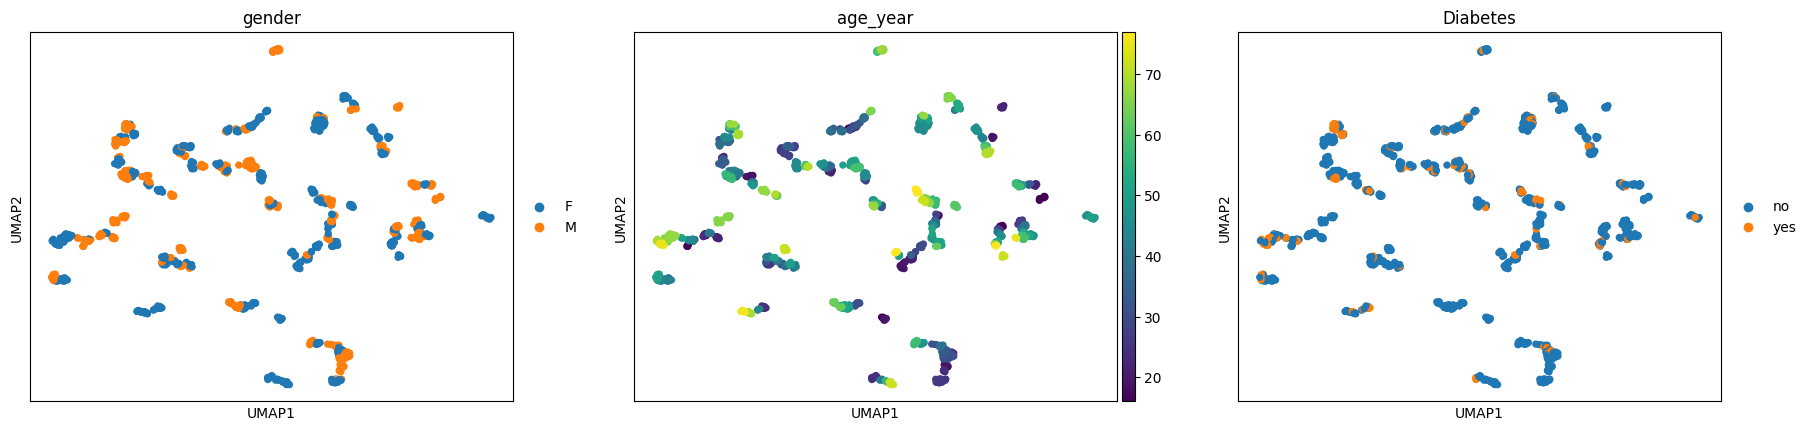

In [12]:
ep.pl.umap(ep_medcat, color=["gender", "age_year", "Diabetes"])

Passing an AnnData object instead of an ehrapy MedCAT object will also work, but not with extracted entities.

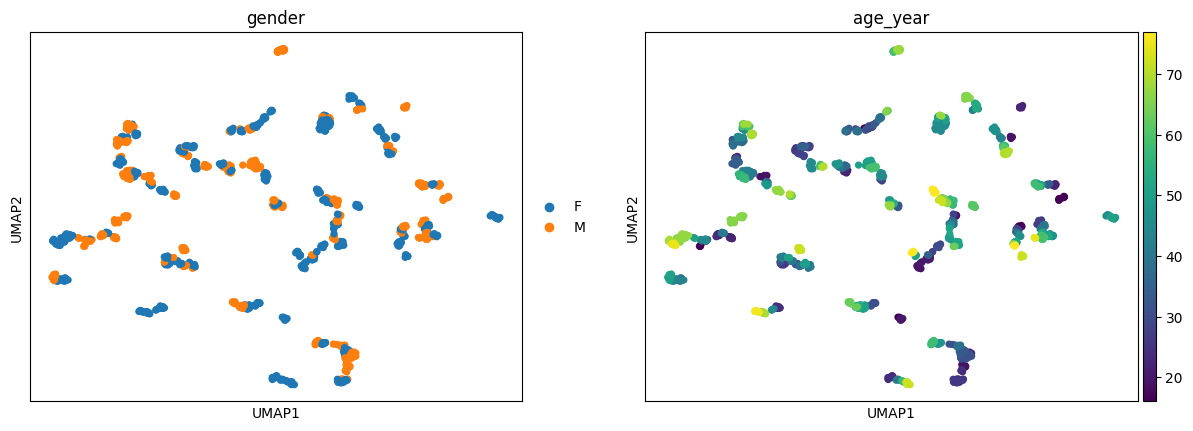

In [13]:
ep.pl.umap(ep_medcat.anndata, color=["gender", "age_year"])

Typos are automatically fixed by ehrapy whenever possible.

Did not find Diubetes in MedCAT's extracted entities. Will use best match Diabetes!

Did not find Heart Failure in MedCAT's extracted entities. Will use best match Heart failure!

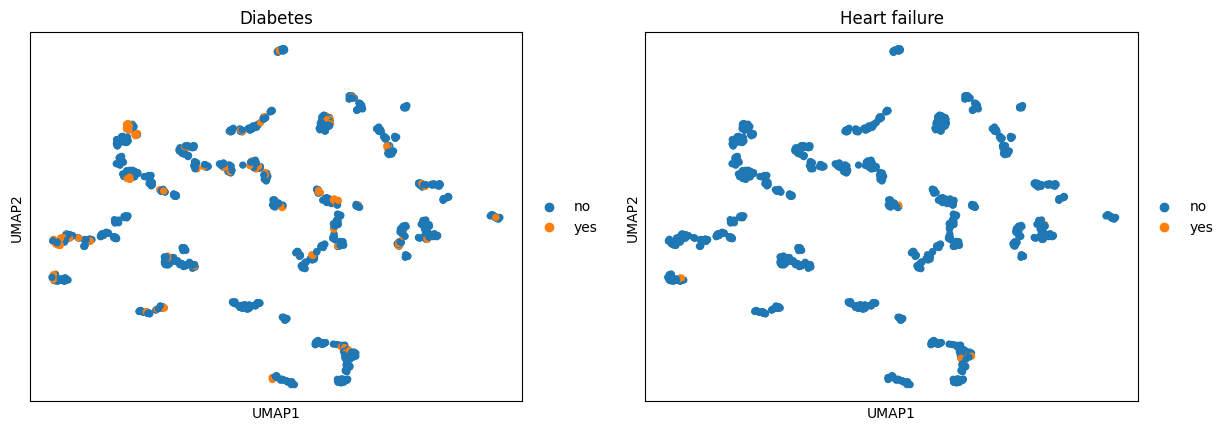

In [14]:
ep.pl.umap(ep_medcat, color=["Diubetes", "Heart Failure"])

All other features of ehrapy are of course also available.

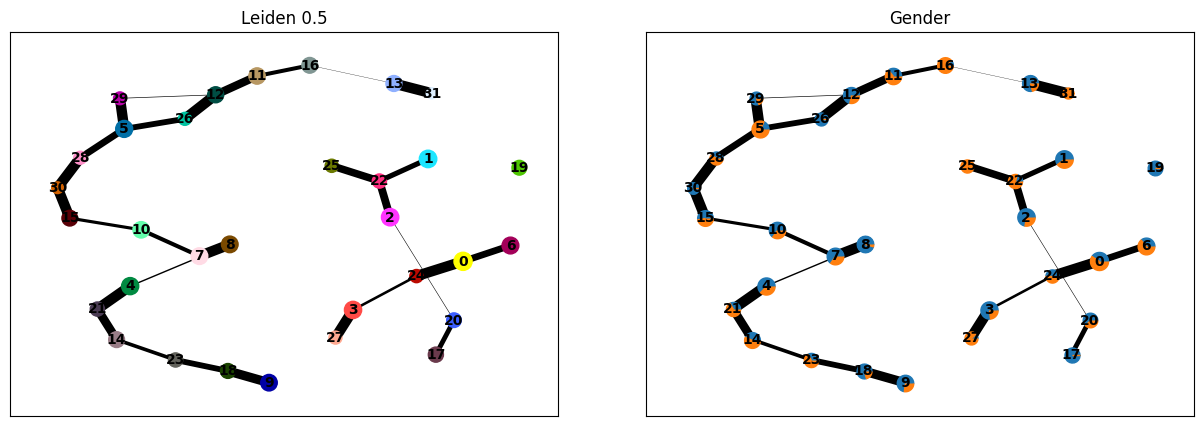

In [15]:
ep.tl.leiden(ep_medcat.anndata, resolution=0.5, key_added="leiden_0_5")
ep.tl.paga(ep_medcat.anndata, groups="leiden_0_5")

# paga currently does not support medcat extracted entities directly (as of ehrapy 0.2.0)
ep.pl.paga(
    ep_medcat.anndata,
    color=["leiden_0_5", "gender"],
    cmap=ep.pl.Colormaps.grey_red.value,
    title=["Leiden 0.5", "Gender"],
)

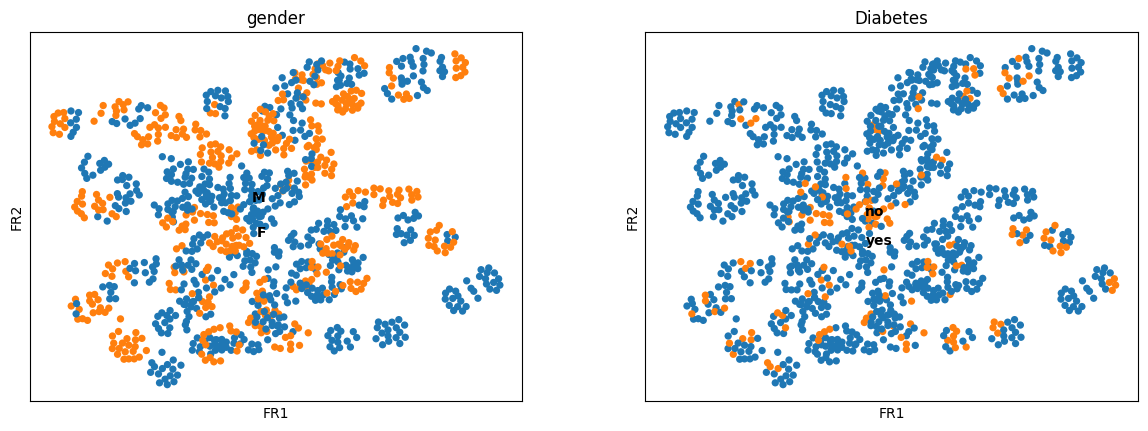

In [16]:
ep.tl.draw_graph(ep_medcat.anndata, init_pos="paga")
ep.pl.draw_graph(ep_medcat, color=["gender", "Diabetes"], legend_loc="on data")

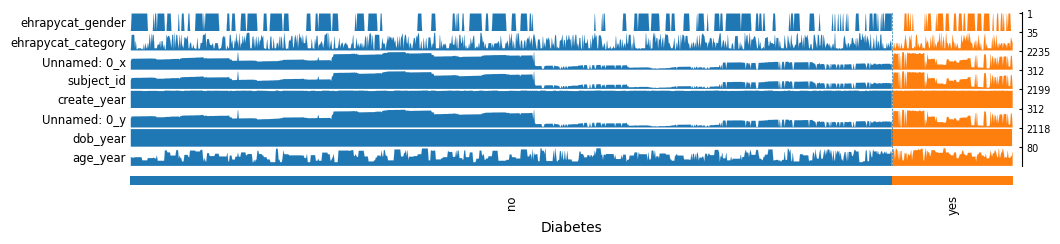

In [17]:
ep.pl.tracksplot(ep_medcat, list(ep_medcat.anndata.var_names), groupby="Diabetes")